#### Configure project

In [2]:
# !cd .. && mkdir build
# !cd ../build/ && rm -rf *
# !rm -f *.so
# !cd ../build && cmake -DCMAKE_BUILD_TYPE=Release ..

#### Compile and install

In [3]:
# !cd ../build && make install

#### Imports

In [4]:
import kNN
import pandas as pd
import numpy as np
from tqdm.notebook import trange,tqdm
import timeit
np.random.seed(1998)

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,5)

#### Utils

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

labels_ = [0,1,2,3,4,5,6,7,8,9]
label_count_ = 10

def data_labels(dataset):
    return (dataset[dataset.columns[1:]].values, dataset["label"].values.reshape(-1,1))

def save_df(df, name):
    df.to_csv("res/{}.csv".format(name), index=False, header=True)

# Returns k splits of dataset (indexes)
def Kfold_gen_splits(dataset, K):
    return KFold(n_splits=K, shuffle=True, random_state=None).split(dataset)

# Returns ((train_data, train_labels),(val_data, val_labels)) pair
def Kfold_get_split(dataset, split):
    train, test = split
    return (data_labels(dataset.iloc[train]), data_labels(dataset.iloc[test]))

def metrics(true_labels, pred_labels):
    accuracy = accuracy_score(y_true=true_labels, y_pred=pred_labels)
    precision = precision_score(y_true=true_labels, y_pred=pred_labels, labels=labels_, average='weighted', zero_division=0)
    recall = recall_score(y_true=true_labels, y_pred=pred_labels, labels=labels_, average='weighted', zero_division=0)
    f1 = f1_score(y_true=true_labels, y_pred=pred_labels, labels=labels_, average='weighted', zero_division=0)
    return [accuracy, precision, recall, f1]

def kNN_Kfold(dataset, K, ks, results, pbar_splits=False, pbar_ks=False):
    splits = Kfold_gen_splits(dataset, K)
    clf = kNN.KNNClassifier(0, label_count_)
    dataset_size = dataset.shape[0]
    ks_pbar = tqdm(total=len(ks), disable=not(pbar_ks))
    for split in tqdm(list(splits), disable=not(pbar_splits)):
        train_folds, test_fold = Kfold_get_split(dataset, split)
        clf.fit(train_folds[0], train_folds[1])
        for k in ks:
            clf.setneighbors(k)
            pred_labels = clf.predict(test_fold[0])
            results.loc[len(results)] = [K, k, dataset_size] + metrics(test_fold[1], pred_labels)
            ks_pbar.update()
        ks_pbar.refresh()
        ks_pbar.reset()
    return results

#### Load dataset

In [7]:
df_train = pd.read_csv("../data/fashion-mnist_train.csv")
df_test = pd.read_csv("../data/fashion-mnist_test.csv")
label_description = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

2    0.1
9    0.1
6    0.1
0    0.1
3    0.1
4    0.1
5    0.1
8    0.1
7    0.1
1    0.1
Name: label, dtype: float64


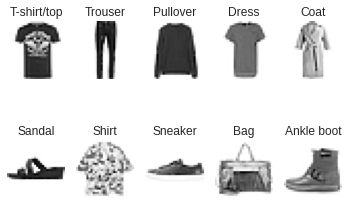

In [8]:
# Check label distribution
print(df_train["label"].value_counts(normalize=True))

# Visualize
examples = df_train.groupby("label").sample(1)
fig = plt.figure()
for i in range(0,10):
    fig.add_subplot(2, 5, i+1)
    example = examples.iloc[i].to_numpy()
    plt.imshow(example[1:].reshape(28,28))
    plt.axis('off')
    plt.title(label_description[example[0]])

In [9]:
# Reduced dataset to test
df_train_small = df_train.groupby("label").sample(300)

## Experimentation

In [10]:
columns = ["K", "k", "size", "accuracy", "precision", "recall", "f1"]

### Cross validation

#### Leave-One-Out CV

In [11]:
# K = df_train_small.shape[0]
# k = 1
# results = pd.DataFrame(columns=columns)
# kNN_Kfold(df_train_small, K, [k], results, True)
# save_df(results, 'LOOCV')

#### KFold CV

In [12]:
# Ks = np.arange(2, 30+2, 1)
# k = 1
# results = pd.DataFrame(columns=columns)
# for K in tqdm(Ks, position=0, leave=True):
#     kNN_Kfold(df_train_small, K, [k], results)
# save_df(results, "KFold_K")

Text(0, 0.5, 'Accuracy')

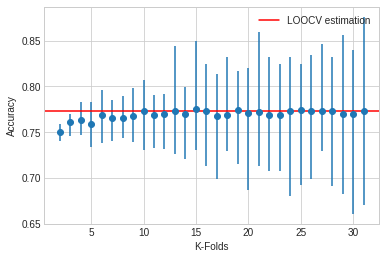

In [13]:
df = pd.read_csv('res/KFold_K.csv').groupby('K')
means = df['accuracy'].mean().to_numpy()
mins = means - df['accuracy'].min().to_numpy()
maxs = df['accuracy'].max().to_numpy() - means
Ks = list(df['K'].unique())
ideal = pd.read_csv('res/LOOCV.csv')['accuracy'].mean()
plt.errorbar(Ks, means, yerr=[mins, maxs], fmt='o')
plt.axhline(y=ideal, color='r', label='LOOCV estimation')
plt.legend()
plt.xlabel('K-Folds')
plt.ylabel('Accuracy')

K=10 seems to be a reasonable value

In [14]:
K_ = 10

### kNN analysis

#### Accuracy

**Dataset size variable**
1. Fixed k (1)
2. Variable k proportional to dataset size

In [15]:
sizes = np.arange(10, df_train_small.shape[0]+1, 10)
df = df_train_small.groupby("label")

In [16]:
# # 1.
# k = 1
# results = pd.DataFrame(columns=columns)
# for size in tqdm(sizes):
#     kNN_Kfold(df.sample(size//10), K_, [k], results)
# save_df(results, "kNN_k_fixed")

In [17]:
# # 2
# results = pd.DataFrame(columns=columns)
# for size in tqdm(sizes):
#     k = size // 10
#     kNN_Kfold(df.sample(size//10), K_, [k], results)
# save_df(results, "kNN_k_proportional")

Text(0, 0.5, 'Accuracy')

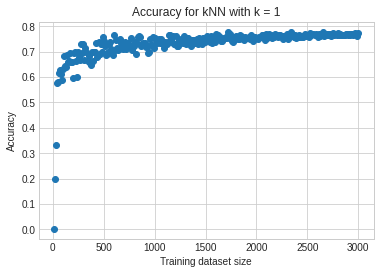

In [18]:
df = pd.read_csv("res/kNN_k_fixed.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
plt.scatter(x=sizes ,y=accuracies, label='accuracy')
plt.title("Accuracy for kNN with k = 1")
plt.xlabel("Training dataset size")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

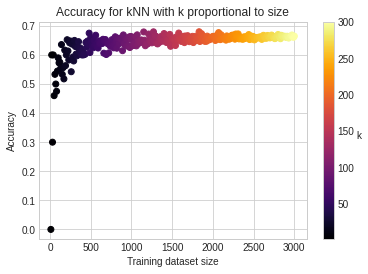

In [19]:
df = pd.read_csv("res/kNN_k_proportional.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
ks = df['k'].unique()
g = plt.scatter(x=sizes, y=accuracies, c=ks, cmap='inferno')
cbar = plt.colorbar(g)
cbar.set_label('k', rotation=0)
plt.title("Accuracy for kNN with k proportional to size")
plt.xlabel("Training dataset size")
plt.ylabel("Accuracy")

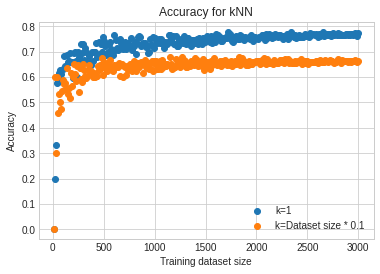

In [20]:
df = pd.read_csv("res/kNN_k_fixed.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
plt.scatter(x=sizes ,y=accuracies, label="k=1")
df = pd.read_csv("res/kNN_k_proportional.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
ks = df['k'].unique()
plt.scatter(x=sizes, y=accuracies, label="k=Dataset size * 0.1")
plt.title("Accuracy for kNN")
plt.xlabel("Training dataset size")
plt.ylabel("Accuracy")
plt.legend()

**Fixed dataset size**
1. k variable (linear)
2. k variable (log)

In [21]:
# # 1
# ks = np.arange(1,200,1)
# results = pd.DataFrame(columns=columns)
# kNN_Kfold(df_train_small, K_, ks, results, True, True)
# save_df(results, "kNN_k_linspace")

In [22]:
# # 2
# ks = np.unique(np.geomspace(1, df_train_small.shape[0] - df_train_small.shape[0]//K_).astype(int))
# results = pd.DataFrame(columns=columns)
# kNN_Kfold(df_train_small, K_, ks, results, True, True)
# save_df(results, "kNN_k_logspace")

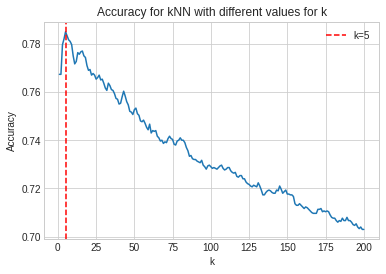

In [23]:
df = pd.read_csv("res/kNN_k_linspace.csv").groupby('k')
accuracies = df['accuracy'].mean().to_numpy()
ks = df['k'].unique()
maxk = ks[accuracies.argmax()+1]
plt.plot(ks, accuracies)
plt.axvline(maxk, color='r', ls='--', label='k='+str(int(maxk[0])))
plt.title("Accuracy for kNN with different values for k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

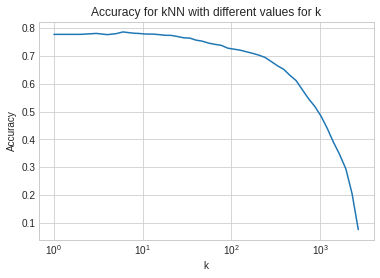

In [24]:
df = pd.read_csv("res/kNN_k_logspace.csv").groupby('k')
accuracies = df['accuracy'].mean().to_numpy()
ks = df['k'].unique()
maxk = ks[accuracies.argmax()+1]
plt.plot(ks, accuracies)
plt.xscale('log')
plt.title("Accuracy for kNN with different values for k")
plt.xlabel("k")
plt.ylabel("Accuracy")

#### Performance

k proportional to training dataset size

In [25]:
perf_data, perf_labels = data_labels(df_train_small)

In [26]:
# clf = kNN.KNNClassifier(1, label_count_)
# sizes = np.arange(1, 1001, 1)
# times = []
# results = pd.DataFrame(columns=['size', 'time', 'k'])
# for size in tqdm(sizes):
#     clf.fit(perf_data[0:size], perf_labels[0:size])
#     clf.setneighbors(size)
#     results.loc[len(results)] = [size, (timeit.timeit(lambda: clf.predict(perf_data[0]), number = 20)/20),size]
# save_df(results, "kNN_perf_k_proportional")

  0%|          | 0/1000 [00:00<?, ?it/s]

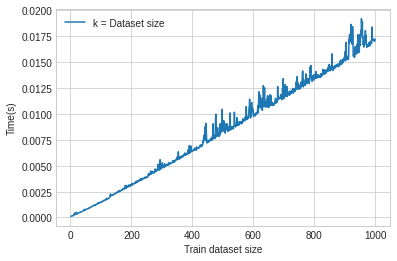

In [39]:
df = pd.read_csv("res/kNN_perf_k_proportional.csv")
plt.plot(df['size'], df['time'], label='k = Dataset size')
plt.xlabel("Train dataset size")
plt.ylabel("Time(s)")
plt.legend()

Fixed k, training dataset size variable

In [35]:
clf = kNN.KNNClassifier(1, 10)
sizes = np.arange(1, 1001, 1)
times = []
results = pd.DataFrame(columns=['size', 'time', 'k'])
for size in tqdm(sizes):
    clf.fit(perf_data[0:size], perf_labels[0:size])
    results.loc[len(results)] = [size, (timeit.timeit(lambda: clf.predict(perf_data[0]), number = 100)/100), 1]
save_df(results, 'kNN_perf_k_fixed')

  0%|          | 0/1000 [00:00<?, ?it/s]

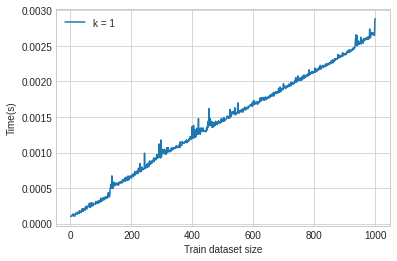

In [41]:
df = pd.read_csv("res/kNN_perf_k_fixed.csv")
plt.plot(df['size'], df['time'], label='k = 1')
plt.xlabel("Train dataset size")
plt.ylabel("Time(s)")
plt.legend()

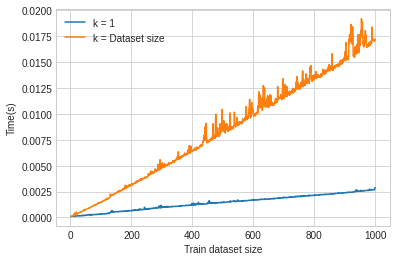

In [40]:
df_kfixed = pd.read_csv("res/kNN_perf_k_fixed.csv")
df_kprop = pd.read_csv("res/kNN_perf_k_proportional.csv")
plt.plot(df_kfixed['size'], df_kfixed['time'], label='k = 1')
plt.plot(df_kprop['size'], df_kprop['time'], label='k = Dataset size')
plt.xlabel("Train dataset size")
plt.ylabel("Time(s)")
plt.legend()

### PCA analysis

In [42]:
# Fit PCA
train_data, train_labels = data_labels(df_train_small)
pca = kNN.PCA(train_data.shape[1])
pca.fit(train_data)

#### Principal component number

##### Scree plot

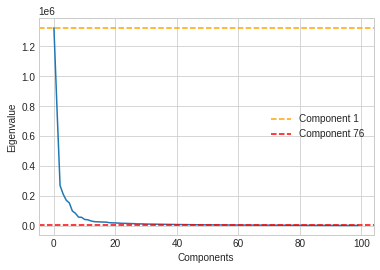

In [55]:
values = pca.pc_values()
plt.plot(values[0:100])
plt.axhline(y=values[0], color='orange', linestyle='--', label='Component 1')
plt.axhline(y=values[76], color='r', linestyle='--', label='Component 76')
plt.xlabel("Components")
plt.ylabel("Eigenvalue")
plt.legend()

##### Cumulative explained variance

Text(0, 0.5, 'Variance explained')

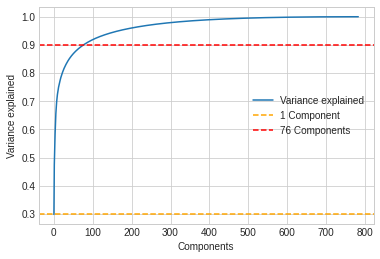

In [51]:
ratios = pca.pc_values()/sum(values)
var_accum = ratios.cumsum()
plt.plot(var_accum, label='Variance explained')
plt.axhline(y=var_accum[0], color='orange', linestyle='--', label='1 Component')
plt.axhline(y=var_accum[76], color='r', linestyle='--', label='76 Components')
plt.legend()
plt.xlabel("Components")
plt.ylabel("Variance explained")

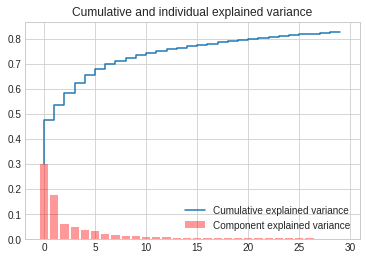

In [47]:
values = pca.pc_values()
ratios = values/sum(values)
var_accum = ratios.cumsum()
plt.bar(range(0,30,1), ratios[0:30], alpha=0.4, color='red', label='Component explained variance')
plt.step(range(0,30,1), var_accum[0:30], label='Cumulative explained variance')
plt.title("Cumulative and individual explained variance")
plt.legend()

##### kNN + PCA

Now lets see how alpha affects kNN accuracy

In [ ]:
ks = np.arange(5, 20, 1)
alphas = np.arange(25, 75,1)
accs = []
clf = kNN.KNNClassifier(1, 10)
for alpha in tqdm(alphas):
    pca.setalpha(alpha)
    train_vectors_t = pca.transform(train_vectors)
    for k in ks:
        clf.setneighbors(k)
        clf.fit(train_vectors_t, train_labels)
        pred_labels = clf.predict(val_vectors)
        accs.append(accuracy_score(val_labels, pred_labels))
    save_res(["k","acc"], zip(ks, accs), "kNN-acc-kvariable")

In [74]:
def kNN_PCA_Kfold(dataset, K, ks, alphas, results, pbar_splits=False, pbar_ks=False, pbar_alphas=False):
    splits = Kfold_gen_splits(dataset, K)
    clf = kNN.KNNClassifier(0, label_count_)
    dataset_size = dataset.shape[0]
    ks_pbar = tqdm(total=len(ks), disable=not(pbar_ks))
    ks_pbar.set_description("k loop")
    alphas_pbar = tqdm(total=len(alphas), disable=not(pbar_alphas))
    alphas_pbar.set_description("alpha loop")
    for split in tqdm(list(splits), disable=not(pbar_splits), prefix="fold loop"):
        train_folds, test_fold = Kfold_get_split(dataset, split)
        pca = kNN.PCA(train_folds[0].shape[1])
        pca.fit(train_folds[0])
        for alpha in alphas:
            pca.setalpha(alpha)
            train_folds_t = pca.transform(train_folds[0])
            clf.fit(train_folds_t, train_folds[1])
            for k in ks:
                clf.setneighbors(k)
                pred_labels = clf.predict(test_fold[0])
                results.loc[len(results)] = [K, k, alpha, dataset_size] + metrics(test_fold[1], pred_labels)
                ks_pbar.update()
            alphas_pbar.update()
            ks_pbar.refresh()
            ks_pbar.reset()
        alphas_pbar.refresh()
        alphas_pbar.reset()

In [62]:
columns = ["K", "k", "alpha", "size", "accuracy", "precision", "recall", "f1"]

In [75]:
ks = np.arange(5, 6, 1)
alphas = np.arange(29, 30,1)
results = pd.DataFrame(columns=columns)
kNN_PCA_Kfold(df_train_small, K_, ks, alphas, results, True, True, True)
save_df(results, 'kNN_PCA_k_alpha_variable')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not iterable

In [69]:
save_df(results, 'kNN_PCA_k_alpha_variable')

### PCA & t-sne

In [ ]:
pca.setalpha(2)
train_vectors_t = pca.transform(train_vectors)
df = pd.DataFrame(train_vectors_t, columns=["x","y"])
df["label"] = train_labels
g = sns.scatterplot(data=df, x='x', y='y', hue='label', palette=sns.color_palette("hls",10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=50, early_exaggeration=20, learning_rate=500, init='random').fit_transform(train_vectors)
df = pd.DataFrame(X_embedded, columns=["x", "y"])
df["label"] = train_labels
g = sns.scatterplot(data=df, x='x', y='y', hue='label', palette=sns.color_palette("hls",10))

In [ ]:
pca.setalpha(25)
train_vectors_t = pca.transform(train_vectors)
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random').fit_transform(train_vectors_t)
df = pd.DataFrame(X_embedded, columns=["x", "y"])
df["label"] = train_labels
g = sns.scatterplot(data=df, x='x', y='y', hue='label', palette=sns.color_palette("hls",10))